In [1]:
!pip install optuna

In [2]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [3]:
import os
if not os.path.exists('./photos'):
  os.mkdir('./photos')
if not os.path.exists('./data'):
  os.mkdir('./data')

In [4]:
with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/')

In [5]:
df = pd.read_csv('/content/data/heart_disease_uci.csv')

In [6]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [7]:
df = df.drop(['id', 'dataset'], axis=1)
df = df.rename(columns={'num': 'target', 'thalch': 'thalach'})

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [9]:
df['sex'] = df['sex'].map(lambda x: 1 if x == 'Male' else 0)
df['fbs'] = df['fbs'].map(lambda x: 1 if x == True else 0)
df['exang'] = df['exang'].map(lambda x: 1 if x == True else 0)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,typical angina,145.0,233.0,1,lv hypertrophy,150.0,0,2.3,downsloping,0.0,fixed defect,0
1,67,1,asymptomatic,160.0,286.0,0,lv hypertrophy,108.0,1,1.5,flat,3.0,normal,2
2,67,1,asymptomatic,120.0,229.0,0,lv hypertrophy,129.0,1,2.6,flat,2.0,reversable defect,1
3,37,1,non-anginal,130.0,250.0,0,normal,187.0,0,3.5,downsloping,0.0,normal,0
4,41,0,atypical angina,130.0,204.0,0,lv hypertrophy,172.0,0,1.4,upsloping,0.0,normal,0


In [10]:
df = df.dropna(subset=['age', 'cp', 'restecg', 'slope', 'thal'])

In [11]:
from sklearn.preprocessing import OneHotEncoder
# ['cp', 'restecg', 'slope', 'thal']
col_to_encode = ['cp', 'restecg', 'slope', 'thal']
encoder = OneHotEncoder()
embarked_encoded = encoder.fit_transform(df[col_to_encode])
df = pd.concat([
    df,
    pd.DataFrame(embarked_encoded.toarray(),
                 columns=encoder.get_feature_names_out(col_to_encode))
], axis=1)
df = df.drop(col_to_encode, axis=1)

In [12]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [13]:
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 0 to 384
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       385 non-null    float64
 1   sex                       385 non-null    float64
 2   trestbps                  384 non-null    float64
 3   chol                      385 non-null    float64
 4   fbs                       385 non-null    float64
 5   thalach                   385 non-null    float64
 6   exang                     385 non-null    float64
 7   oldpeak                   385 non-null    float64
 8   ca                        299 non-null    float64
 9   target                    468 non-null    int64  
 10  cp_asymptomatic           385 non-null    float64
 11  cp_atypical angina        385 non-null    float64
 12  cp_non-anginal            385 non-null    float64
 13  cp_typical angina         385 non-null    float64
 14  restecg_lv hype

In [15]:
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,cp_typical angina,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,slope_downsloping,slope_flat,slope_upsloping,thal_fixed defect,thal_normal,thal_reversable defect
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [16]:
# Rellenar NaN por mediana
df = df.fillna(df.median())

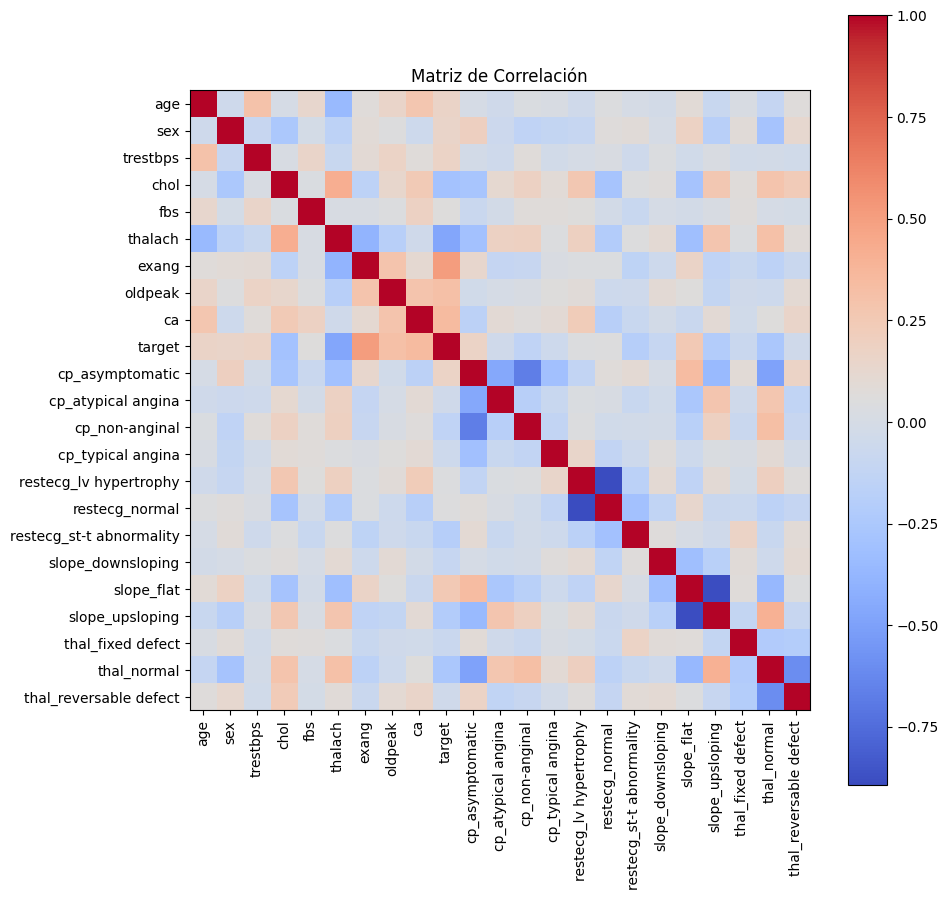

In [17]:
# Matriz de correlacion
corr_matrix = df.corr()
plt.figure(figsize=(10, 10))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()
plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90)
plt.yticks(np.arange(len(df.columns)), df.columns)
plt.title('Matriz de Correlación')
plt.savefig('./photos/correlation_matrix.png')
plt.show()

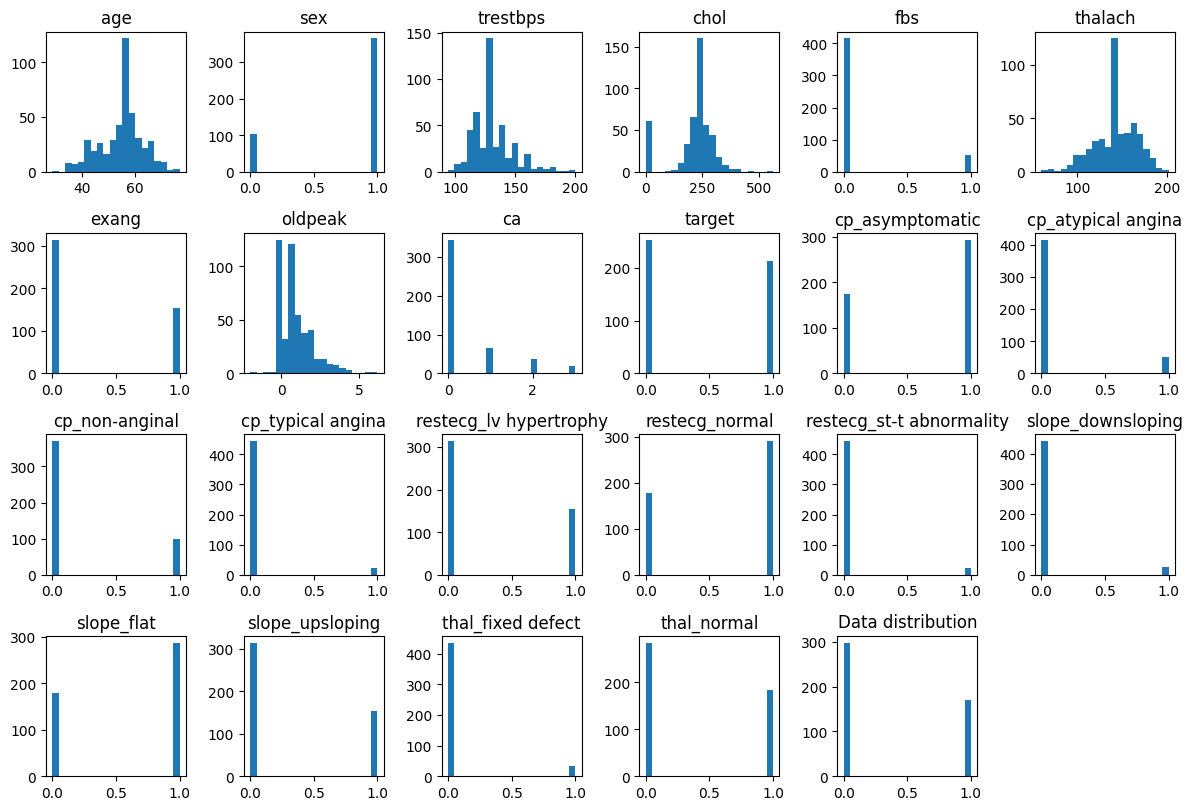

In [18]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(df.columns):
    plt.subplot(6, 6, i+1)
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.tight_layout()
plt.title("Data distribution")
plt.savefig('./photos/distributions.png')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [20]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
rf_prediction = prediction = rf_model.predict(X_test)

In [22]:
from sklearn.metrics import f1_score

rf_score = f1_score(y_test, rf_prediction)
rf_score

0.8941176470588236

In [23]:
rf_model.feature_importances_

array([0.10569041, 0.02572035, 0.08589655, 0.13003601, 0.00796993,
       0.17134923, 0.09670687, 0.12214783, 0.08167322, 0.02060329,
       0.00717716, 0.01400889, 0.00891622, 0.01632751, 0.01149414,
       0.00314709, 0.00385831, 0.02326105, 0.01496774, 0.005748  ,
       0.02562017, 0.01768004])

In [24]:
import builtins

columns_importances = pd.DataFrame(rf_model.feature_importances_)
feature_importances = {name: score for name, score in builtins.zip(list(X_train), columns_importances[0])}

In [25]:
reduced_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:8]
reduced_features

['thalach', 'chol', 'oldpeak', 'age', 'exang', 'trestbps', 'ca', 'sex']

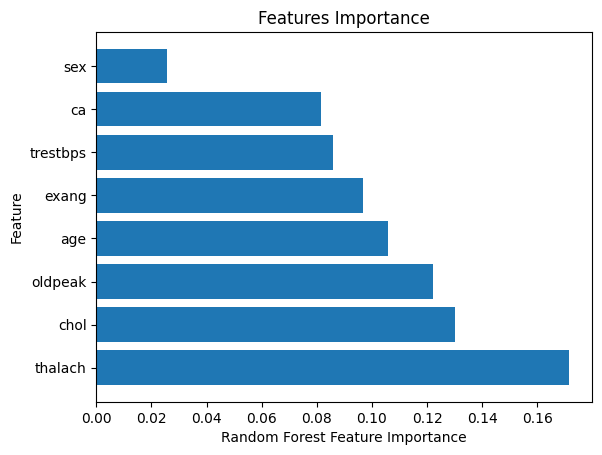

In [26]:
plt.barh(reduced_features, [feature_importances[x] for x in reduced_features])
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("Feature")
plt.title("Features Importance")
plt.savefig('./photos/feature_importance.png')
plt.show()

In [27]:
X_train_reduced = X_train[reduced_features]
X_test_reduced = X_test[reduced_features]

In [28]:
rf_model_reduced = RandomForestClassifier()
rf_model_reduced.fit(X_train_reduced, y_train)

RandomForestClassifier()

In [29]:
reduced_prediction = rf_model_reduced.predict(X_test_reduced)

In [30]:
reduced_score = f1_score(y_test, reduced_prediction)
reduced_score

0.9090909090909091

In [31]:
from sklearn.model_selection import GridSearchCV
parameters = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 15, 30],
'min_samples_split': [2,10],
'min_samples_leaf': [1, 2],
'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=rf_model_reduced, param_grid=parameters, cv=5, n_jobs=-1, verbose=2)
grid_search

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 15, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [32]:
grid_search.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 15, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [33]:
best_parameters = grid_search.best_params_

In [34]:
rf_best_params = RandomForestClassifier(**best_parameters)
rf_best_params.fit(X_train_reduced, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=50)

In [35]:
grid_prediction = rf_best_params.predict(X_test_reduced)

In [36]:
grid_score = f1_score(y_test, grid_prediction)
grid_score

0.8735632183908046

In [37]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X_train, y_train)

PCA(n_components=8)

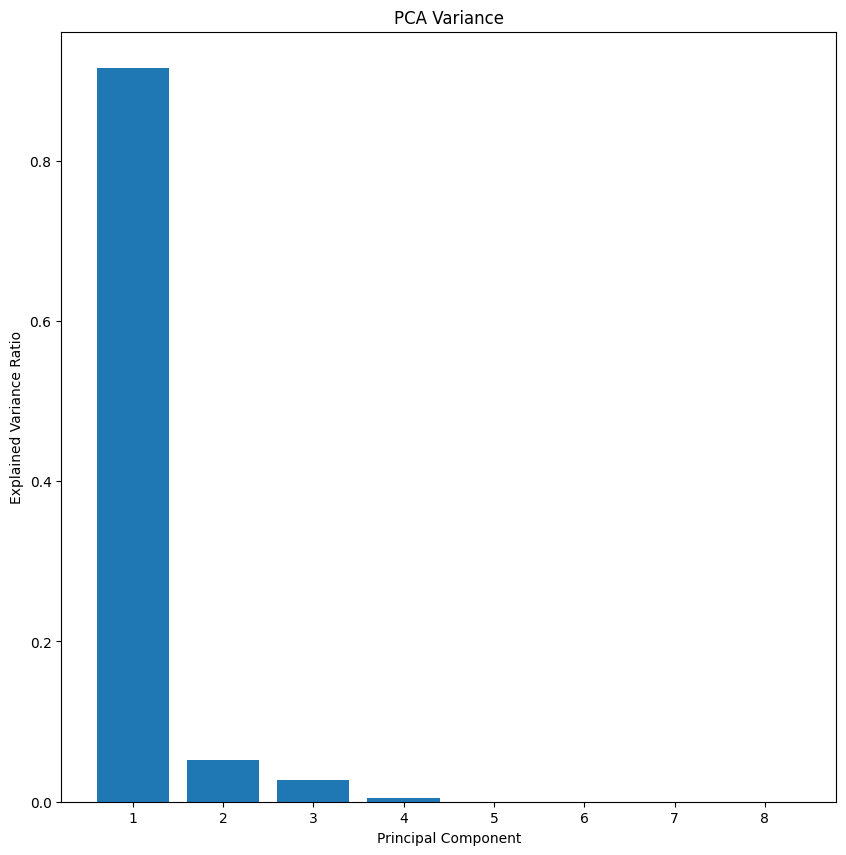

In [38]:
# pca variance
plt.figure(figsize=(10, 10))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Variance')
plt.savefig('./photos/pca_variance.png')
plt.show()

In [39]:
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_test)

In [40]:
rf_model_pca = RandomForestClassifier()
rf_model_pca.fit(pca_train, y_train)

RandomForestClassifier()

In [41]:
pca_prediction = rf_model_pca.predict(pca_test)

In [42]:
pca_score = f1_score(y_test, pca_prediction)
pca_score

0.8735632183908046

In [43]:
from sklearn.model_selection import cross_val_score
def objective(trial):
  common_params = {
       "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
       "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
       "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
  }
  params = {
    **common_params,
    "n_estimators": trial.suggest_int("n_estimators", 100, 200),
  }
  model = RandomForestClassifier(**params)

  score = cross_val_score(model, X_train, y_train, cv=5).mean()
  return score

In [44]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400)

[I 2025-11-11 11:16:08,360] A new study created in memory with name: no-name-7ce55964-ad82-4378-96aa-36955620b135
[I 2025-11-11 11:16:09,246] Trial 0 finished with value: 0.836972972972973 and parameters: {'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'n_estimators': 150}. Best is trial 0 with value: 0.836972972972973.
[I 2025-11-11 11:16:10,141] Trial 1 finished with value: 0.8423783783783783 and parameters: {'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'n_estimators': 156}. Best is trial 1 with value: 0.8423783783783783.
[I 2025-11-11 11:16:11,154] Trial 2 finished with value: 0.837009009009009 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'n_estimators': 174}. Best is trial 1 with value: 0.8423783783783783.
[I 2025-11-11 11:16:11,964] Trial 3 finished with value: 0.8423423423423424 and parameters: {'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'n_estimators': 140}. 

In [45]:
best_trial = study.best_trial
print("Best trial:")
print("  Value: ", best_trial.value)

Best trial:
  Value:  0.8690810810810812


In [46]:
study.best_params

{'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'n_estimators': 189}

In [47]:
rf_model_optimized = RandomForestClassifier(**study.best_params)
rf_model_optimized.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                       min_samples_split=4, n_estimators=189)

In [48]:
optuna_prediction = rf_model_optimized.predict(X_test)

In [49]:
optuna_score = f1_score(y_test, optuna_prediction)
optuna_score

0.8809523809523809

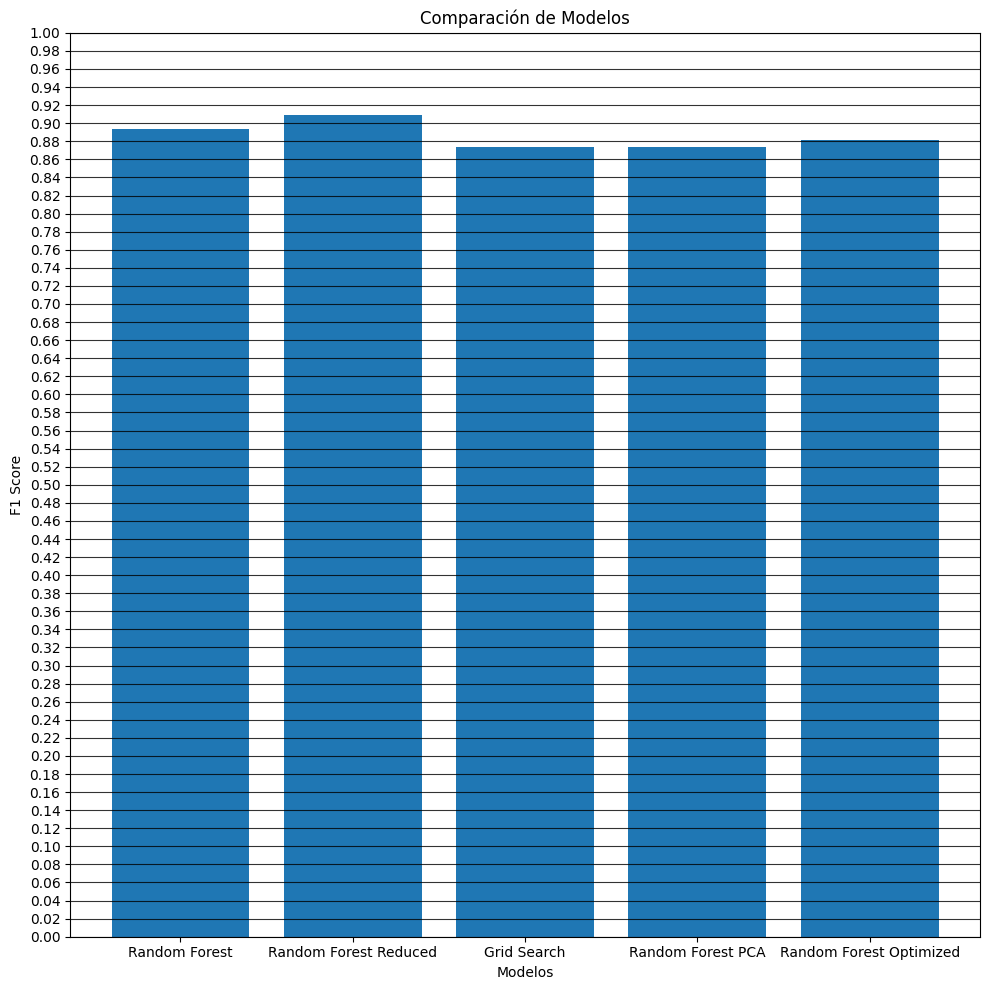

In [50]:
# Comparación resultados
plt.figure(figsize=(10, 10))
plt.bar([f'Random Forest', f'Random Forest Reduced', f'Grid Search', f'Random Forest PCA', f'Random Forest Optimized'],
        [rf_score, reduced_score, grid_score, pca_score, optuna_score])
plt.xlabel('Modelos')
plt.ylabel('F1 Score')
plt.title('Comparación de Modelos')
plt.ylim([0, 1])

plt.yticks(np.arange(0, 1.01, 0.02))
plt.grid(axis='y', alpha=0.8, color="black")

plt.tight_layout()
plt.savefig('./photos/model_comparison.png')
plt.show()

# Análisis del mejor modelo
## Random Forest Reduced
El modelo que da mejores resultados de media es el random forest sin parámetros unicamente con los 8 atributos con mayor importancia sobre el resultado. En general los modelos varian entre un 87-90% de accuracy pero el que suele mantener valores más altos es el reduced. Los cambios se deben a los valores aleatorios en los entrenamientos.

El valor más diferencial en el modelo con los valores más relevantes con el resultado es la posible ausencia de ruido al quitar los campos poco o nada relevantes para obtener el resultado, lo que hace que el modelo obtenga solamente valores relevantes.

# Análisis crítico
## ○ ¿Qué modelo obtuvo el mejor F1-score?
El modelo entrenado con los 8 campos más relevantes sin parámetros es el que tiene la media de score más alta.
## ○ ¿Por qué crees que ese modelo funcionó mejor?
Debido a que hay campos que no tienen ninguna relevancia para la determinación del resultado, al quitarlos libera al modelo de posible ruido que esté confundiendolo.
## ○ ¿Las optimizaciones mejoraron el baseline? ¿Por qué sí o no?
En general las optimizaciones no han mejorado el modelo. La mayoría de parámetros que se sirven para limitar el modelo para que sea menos pesado/más óptimo, al menos por las pruebas llevadas acabo.
## ○ ¿Qué características son más importantes para predecir enfermedades cardíacas?
Las características más importantes son:
sex, ca, trestbps, exang, age, oldpeak, chol y thalach

## ○ Si el baseline es el mejor, ¿qué nos enseña esto sobre la optimización?
Optimizar un modelo no garantiza que vaya a ser mejor, muchas veces el modelo sin declarar parámetros ya puede ser suficientemente bueno si los datos con los que se le entrenan son buenos y hay una buena cantidad.

# Interpretación medica
  Sex: género

  Age: edad

  trestbps: presión arterial en reposo

  chol: coresterol

  thalach: frecuencia cardíaca máxima alcanzada

  exang: angina inducida por ejercicio

  oldpeak: depresión del segmento ST
  
  ca: número de vasos principales coloreados por fluoroscopia
